<a href="https://colab.research.google.com/github/Stephaaniee/ProjectWork/blob/main/Tst2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
from fastai.data.core import DataLoader
import random
import re
import os
import shutil
import PIL
import torch
import numpy as np
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files
from fastai.data.core import DataLoaders
from fastbook import *
import pathlib
import tensorflow as tf

In [9]:
set_seed(42)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
#split data
path = r"/content/drive/MyDrive/sugar_beets"
def split_data(source_folder, train_folder, test_folder, test_size):
    for root, dirs, files in os.walk(source_folder):
        if files:
            # paths
            rel_path = os.path.relpath(root, source_folder)
            train_subfolder = os.path.join(train_folder, rel_path)
            test_subfolder = os.path.join(test_folder, rel_path)

            # Create these subfolders if they don't already exist
            os.makedirs(train_subfolder, exist_ok=True)
            os.makedirs(test_subfolder, exist_ok=True)

            # Filter out non-image files if necessary
            images = [f for f in files if os.path.isfile(os.path.join(root, f))]

            # Determine the number of images to select for the test set
            num_test_images = int(len(images) * test_size)

            # Randomly select images for the test set
            test_images = random.sample(images, num_test_images)

            # The remaining images will be used for the training set
            train_images = [img for img in images if img not in test_images]

            # Copy the training images to the train subfolder
            for img in train_images:
                shutil.copy(os.path.join(root, img), os.path.join(train_subfolder, img))

            # Copy the testing images to the test subfolder
            for img in test_images:
                shutil.copy(os.path.join(root, img), os.path.join(test_subfolder, img))

            print(f"Processed folder: {rel_path}")
            print(f"Training images: {len(train_images)}")
            print(f"Testing images: {len(test_images)}")

# Paths to the corresponding folders
source_folder = path # Where are the source files?
train_folder = "/content/drive/MyDrive/train_folder" # Where to save the train files?
test_folder = "/content/drive/MyDrive/test_folder" # Where to save the test files?

# Percentage of images to be moved to the test folder
test_size = 0.2

split_data(source_folder, train_folder, test_folder, test_size=test_size)

Processed folder: healthy
Training images: 7325
Testing images: 1831
Processed folder: sick
Training images: 1620
Testing images: 405


In [15]:
#ensuring the images are the same size , label and augument the data
item_tfms = RandomResizedCrop(460, min_scale = 0.75, ratio=(1., 1.)),
batch_tfms = [*aug_transforms(size = 224, max_warp=0), Normalize.from_stats(*imagenet_stats)] #scaling the image to train faster
bs=64

In [16]:
dataTest = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed= 100),
    get_y = using_attr(RegexLabeller(pat = r'([\w]+).\d+..*$'), 'name'),
    # get_y = parent_label,
    item_tfms = RandomResizedCrop(460, min_scale = 0.75, ratio=(1., 1.)),
    batch_tfms = [*aug_transforms(size = 224, max_warp=0), Normalize.from_stats(*imagenet_stats)] #scaling the image to train faster
)

In [17]:
dls = dataTest.dataloaders('/content/drive/MyDrive/train_folder', bs=32)

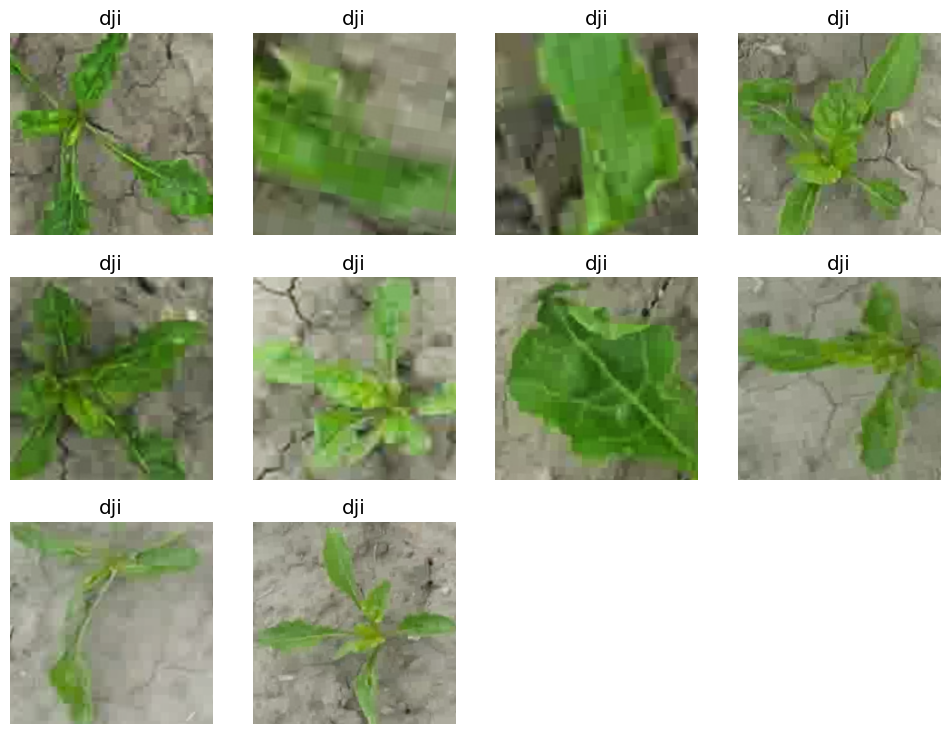

In [18]:
dls.show_batch(max_n=10)

In [19]:
model = vision_learner(dls, resnet34, metrics = error_rate)
model.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 148MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,01:39
1,0.000000,0.000000,0.000000,01:25
2,0.000000,0.000000,0.000000,01:24
3,0.000000,0.000000,0.000000,01:25


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,01:28
1,0.000000,0.000000,0.000000,01:31


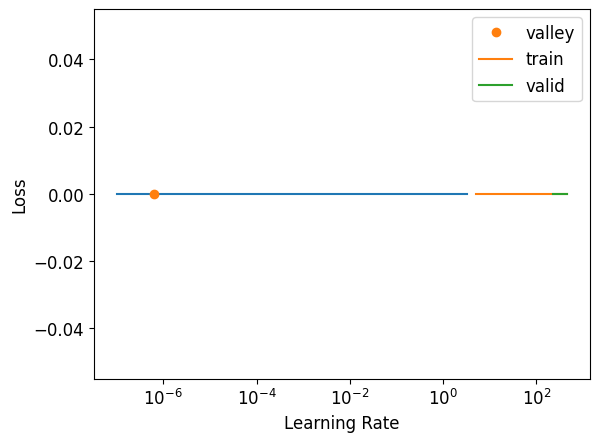

In [20]:
model.unfreeze()
model.lr_find()
model.fit_one_cycle(2, lr_max = slice (2e-5,6e-5)) #modify to the learning rates range you find
model.save("awesome")
model.recorder.plot_loss()

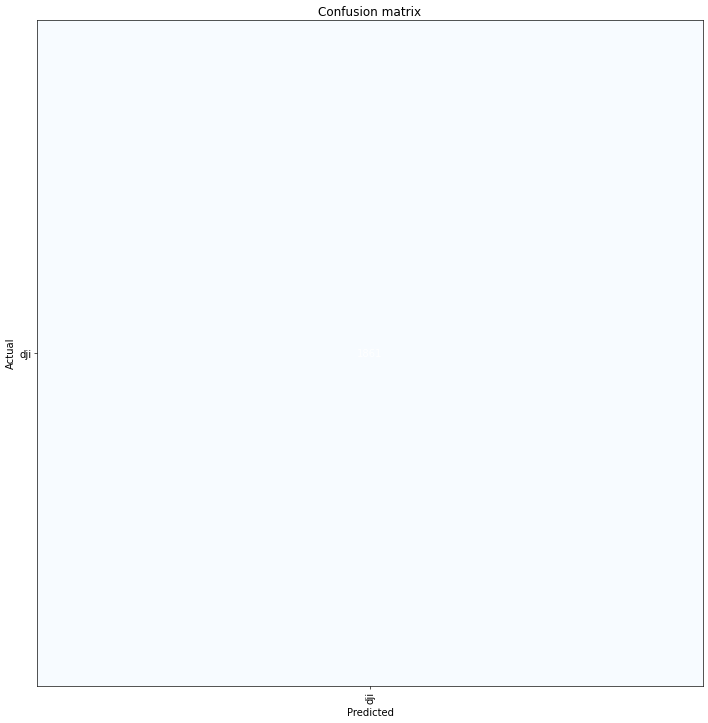

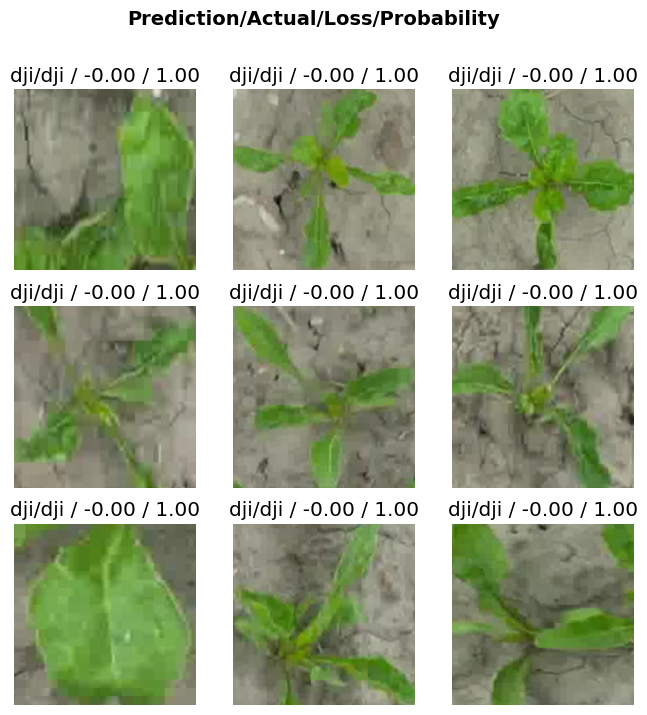

In [21]:
results = ClassificationInterpretation.from_learner(model)
results.plot_confusion_matrix(figsize=(12,12), dpi=60)
results.plot_top_losses(9, figsize = (8, 8))

In [ ]:
https://medium.com/@FastAIButMakeItSlow/image-classification-using-fastai-dogs-vs-cats-project-bbe752a4bcf8
https://course18.fast.ai/lessons/lesson1.html
https://www.youtube.com/watch?v=93kXzUOiYY4